###  Trend Index from trained cnn model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import quandl
from modules.tfmodels import CNN
from modules.factory import ohlc_chart
from IPython.display import clear_output

#### 0. 환경 변수 설정

In [2]:
quandl.ApiConfig.api_key = "UzB-e5CDdoACq4ENxbVS"
METAFILE = 'data/SCF-meta.csv'
TF_FILE = 'data/tf/120day_trend_weight.ckpt'

#quandl 코드
df = pd.read_csv(METAFILE)
df['iid'] = 'SCF/'+df.Exchange+'_'+df.Symbol+'1_OB'
meta = df[['iid','name']]

#tf model loading
sess = tf.Session()
model = CNN(sess, 'trend', period=120)
saver = tf.train.Saver()
saver.restore(sess, TF_FILE)

INFO:tensorflow:Restoring parameters from data/tf/120day_trend_weight.ckpt


#### 1. Trend Index Creation

In [13]:
#랜덤 종목 선택
idx = np.random.randint(0, len(meta))
code = meta.iloc[idx].iid
name = meta.iloc[idx]['name']

#ohlc data 다운로드
raw_data = quandl.get(code)
raw_data.drop(['Volume', 'Prev. Day Open Interest'], axis=1, inplace=True)
    
#trend index
uptrend = []
downtrend = []
neutral = []
date = []
for i in range(len(raw_data)-120):
    clear_output(wait=True)
    win = raw_data[i:i+120]
    data = (win-win.Settle.mean())/raw_data.Settle.std()

    temp = data.values.T
    ref_data = np.stack( (temp[0::4, :], temp[1::4, :], temp[2::4, :], temp[3::4, :]), axis=-1)
    down, neu, up = model.predict(ref_data)[0]
    uptrend.append(up)
    downtrend.append(down)
    neutral.append(neu)
    date.append(data.index[-1])
    print('%s: processing... (%s/%s)'%(name, i, len(raw_data)))

    
#그래프 
#fig, (ax) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 1]}, figsize=(8,8))
#fig.autofmt_xdate()

#ax[0].plot(raw_data.index.values, raw_data.Settle.values)

#plt.show()

CBOT 30-year US Treasury Bond: processing... (2389/2510)


In [5]:
import time

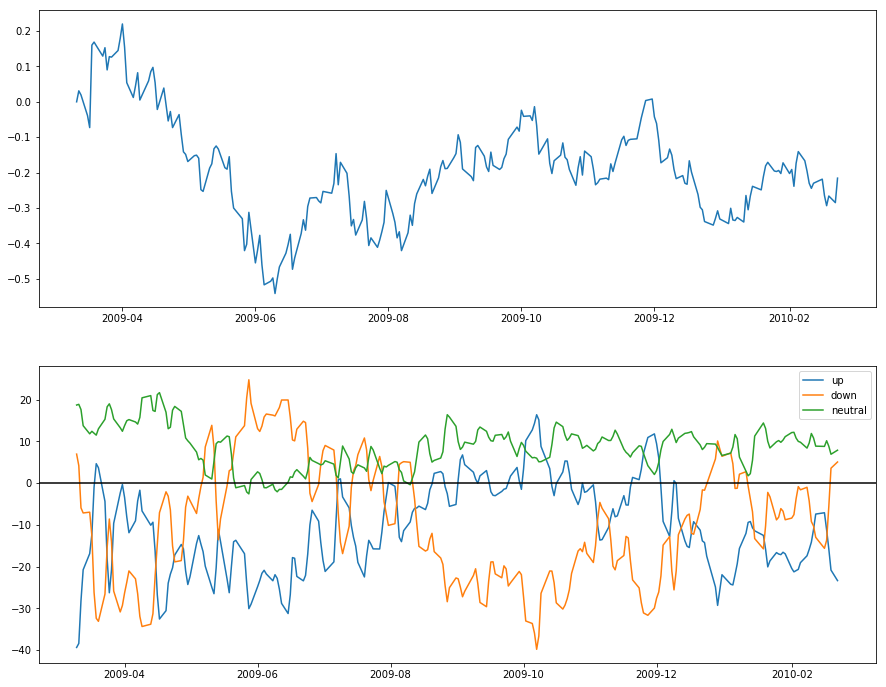

In [ ]:
raw_data2 = raw_data[120:]
std = raw_data.Settle.std()
for i in range(0, len(raw_data2), 5):
    fig, (ax) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 1]}, figsize=(15,12))
    #fig.autofmt_xdate()
    start = i
    window = 240
    data = (raw_data2[i:i+window] - raw_data2.iloc[i])/std 
    ax[0].plot(data.index.values, data.Settle.values)
    ax[1].plot(date[i:i+window], uptrend[i:i+window], label='up')
    ax[1].plot(date[i:i+window], downtrend[i:i+window], label='down')
    ax[1].plot(date[i:i+window], neutral[i:i+window], label='neutral')
    ax[1].axhline(color='black')
    ax[1].legend()
    plt.show()
    time.sleep(0.05)
    clear_output(wait=True)

In [140]:
len(raw_data)

2377

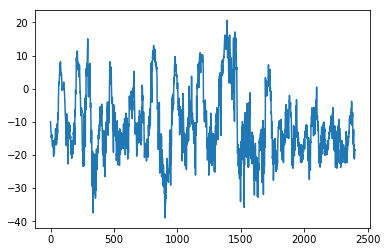

In [113]:
plt.plot(uptrend)

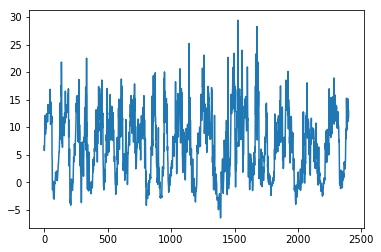

In [114]:
plt.plot(neutral)

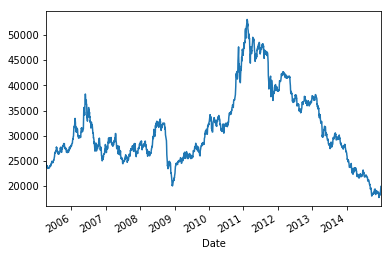

In [115]:
raw_data.Settle.plot()

In [116]:
name

'SHFE Natural Rubber'